In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Dataset/reclean.zip

Archive:  /content/drive/MyDrive/Dataset/reclean.zip
  inflating: reclean.csv             


In [3]:
import numpy as np
import pandas as pd

In [4]:
dataset = pd.read_csv("/content/reclean.csv")
dataset

,sentiment,processed_text
0,0,"<user> <url> - aww, that's a bummer. you shou..."
1,0,is upset that he can't update his facebook by ...
2,0,<user> i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire
4,0,"<user> no, it's not behaving at all. i'm mad. ..."
...,...,...
1599995,1,just woke up. having no school is the best fee...
1599996,1,thewdb.com - very cool to hear old walt interv...
1599997,1,are you ready for your mojo makeover? ask me f...
1599998,1,happy 38th birthday to my boo of all time!! tu...


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size = 0.2, random_state = 0)


In [41]:
X_test.shape

(80000, 60)

In [8]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))


In [9]:
# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 88778


In [10]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [12]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)


X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


In [13]:
len(tokenizer.word_index)

697104

In [14]:
vocab_length = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (697105, 100)


In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [16]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [17]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           69710500  
                                                                 
 bidirectional (Bidirection  (None, 60, 200)           160800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 60, 200)           240800    
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                   

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5),
             ModelCheckpoint("model_best.h5",monitor='val_accuracy', save_best_only=True, mode='max',verbose=1)]

In [24]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs= 30,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/30
1336/1336 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.8049
Epoch 1: val_accuracy improved from -inf to 0.82280, saving model to model_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1336/1336 [==============================] - 162s 115ms/step - loss: 0.4200 - accuracy: 0.8049 - val_loss: 0.3904 - val_accuracy: 0.8228 - lr: 0.0010
Epoch 2/30
1336/1336 [==============================] - ETA: 0s - loss: 0.3985 - accuracy: 0.8174
Epoch 2: val_accuracy improved from 0.82280 to 0.82878, saving model to model_best.h5
1336/1336 [==============================] - 156s 117ms/step - loss: 0.3985 - accuracy: 0.8174 - val_loss: 0.3805 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 3/30
1336/1336 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8236
Epoch 3: val_accuracy improved from 0.82878 to 0.83280, saving model to model_best.h5
1336/1336 [==============================] - 151s 113ms/step - loss: 0.3878 - accuracy: 0.8236 - val_loss: 0.3729 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 4/30
1336/1336 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8274
Epoch 4: val_accuracy improved from 0.83280 to 0.83561, saving model to model_best.h

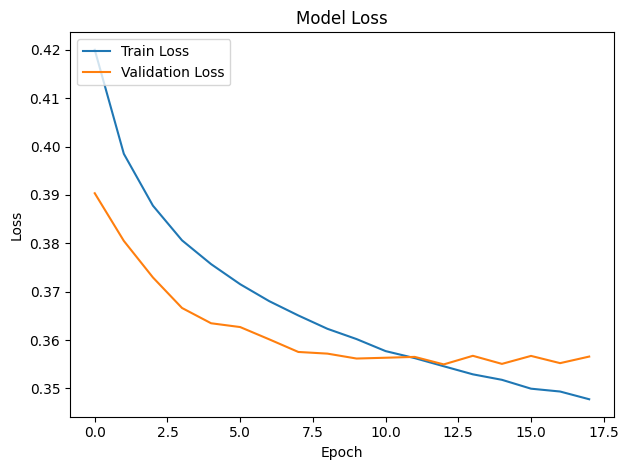

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

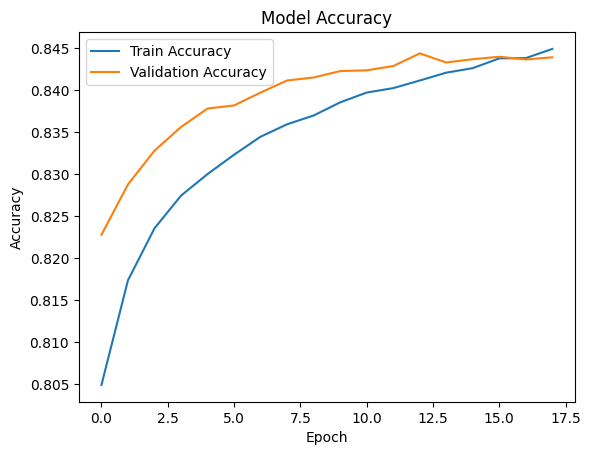

In [27]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:
y_pred=training_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

2500/2500 [==============================] - 17s 6ms/step


In [30]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
accuracy_score(y_test,y_pred)

0.84295

In [39]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[32979,  7010],
       [ 5554, 34457]])

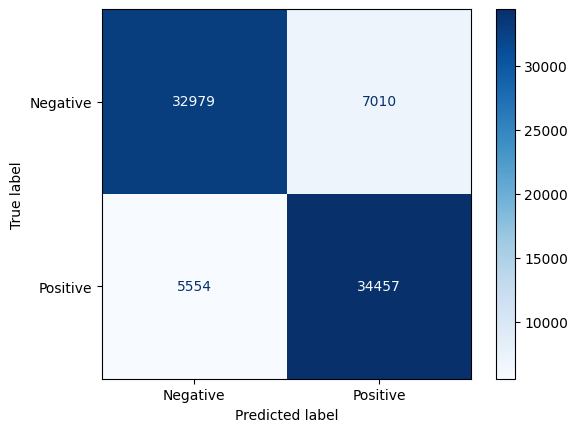

In [38]:
from matplotlib import pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)

In [43]:
from sklearn.metrics import classification_report


In [46]:
print(classification_report(y_pred,y_test) )

              precision    recall  f1-score   support

           0       0.82      0.86      0.84     38533
           1       0.86      0.83      0.85     41467

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000

